In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import json
from collections import Counter

from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier

from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.svm import LinearSVC
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectFromModel

from sklearn.linear_model import LassoCV
from time import time
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("../../our_data/Etap4/GB_US-rdy-to-learn-properly-V2.csv")
df.shape

(8509, 144)

In [3]:
pd.set_option('display.max_columns', None)

def prepeareData(df):
    df = df.drop(['category_id'], axis = 1)
    df = df[ df['category_id_GT'].notna() ]
    y = df.loc[:,'category_id_GT']
    X  = df.loc[:, df.columns != 'category_id_GT']
    X = X.select_dtypes(include=np.number)
    X = X.fillna(-1)
    return X, y


def getFI_RForest(X,y,printF= True,plot = True):
    forest = ExtraTreesClassifier(n_estimators=250,
                                  random_state=0)

    forest.fit(X, y)
    importances = forest.feature_importances_
    std = np.std([tree.feature_importances_ for tree in forest.estimators_],
                 axis=0)
    indices = np.argsort(importances)[::-1]
    df = pd.DataFrame(np.dstack([importances,X.columns])[0])
    if plot:    
        plt.figure(figsize=(10,10))

        plt.title("Feature importances")
        plt.bar(range(X.shape[1]), importances[indices],
                color="r", yerr=std[indices], align="center")
#         plt.bar(range(X.shape[1]), x=np.arange(0,len(df)),
#                 color="r", yerr=std[indices], align="center")
#         plt.xticks(range(X.shape[1]), indices)
        plt.xlim([-1, X.shape[1]])
        plt.show()
    if printF: 
        print("Feature ranking:")
        for f in range(X.shape[1]):
            print("%d. feature %s (%f)" % (f + 1, X.columns[indices[f]], importances[indices[f]]))

    
    return df.sort_values(by=0,ascending=False)

def getFI_Bagging(X,y,printF= True,plot = True):
    clf = BaggingClassifier(DecisionTreeClassifier())
    clf.fit(X, y)

    feature_importances = np.mean([
        tree.feature_importances_ for tree in clf.estimators_
    ], axis=0)

    df = pd.DataFrame(np.dstack([feature_importances,X.columns])[0])
    
    indices = np.argsort(feature_importances)[::-1]

    if plot:
        
        plt.figure(figsize=(10,10))
            
        plt.title("Feature importances")
        plt.bar(range(X.shape[1]), feature_importances[indices],
                color="r",  align="center")
#         plt.bar(range(X.shape[1]),
#                 color="r",  align="center")
#         plt.xticks(range(X.shape[1]), indices)
        plt.xlim([-1, X.shape[1]])
        plt.show()
    if printF: 
        print("Feature ranking:")
        for f in range(X.shape[1]):
            print("%d. feature %s (%f)" % (f + 1, X.columns[indices[f]], feature_importances[indices[f]]))
            
    return df.sort_values(by=0,ascending=False)

def selectFromModelSVC(X,y,printF= True,plot = True):
    lsvc = LinearSVC(C=0.01, penalty="l1", dual=False).fit(X, y)
    model = SelectFromModel(lsvc, prefit=True)
    X_new = model.transform(X)
    feature_idx = model.get_support()
    feature_name = X.columns[feature_idx]    
    if printF:
        print("Before: "+ str(X.shape))
        print("After: "+ str(X_new.shape))        
        print(feature_name)
    return feature_name
def getFILasso(X,y,printF= True,plot = True):
    lasso = LassoCV().fit(X, y)
    importance = np.abs(lasso.coef_)
    feature_names = np.array(X.columns)

    df = pd.DataFrame(np.dstack([importance,X.columns])[0])
    df = df.sort_values(by=0,ascending=False)
    if plot:
        plt.figure(figsize=(10,10))

        plt.bar(height=df[0], x=np.arange(0,len(df)))
        plt.title("Feature importances via coefficients")
        plt.show()
    if printF:
        pd.set_option('display.max_rows', None)        
        print(df.sort_values(by=0,ascending=False))
        pd.set_option('display.max_rows', 20)        

    return df.sort_values(by=0,ascending=False)
    
    


# GB_US data feature importance

In [4]:
X, y = prepeareData(df)
print(df.shape)
df[:3]

(8509, 144)


,category_id_GT,video_id,channel_title,views,likes,dislikes,comment_count,comments_disabled,ratings_disabled,video_error_or_removed,pub_day_of_the_week,pub_month,pub_day,pub_hour,tren_day_of_the_week,tren_month,tren_day,time_to_trend_in_days,dislikes/likes,likes/views,dislikes/views,comment_count/views,increase_views,increase_likes,increase_dislikes,increase_comms,times_in_trend,avg_views,avg_likes,avg_dislikes,avg_comms,avg_views_increase_per_hour,n_of_tags,title_length,title_n_of_words,title_capital_letters,title_capital_letters_percent,title_small_letters,title_small_letters_percent,title_punctuation,title_punctuation_percent,title_n_of_emojis,desc_length,desc_n_of_words,desc_capital_letters,desc_capital_letters_percent,desc_small_letters,desc_small_letters_percent,desc_punctuation,desc_punctuation_percent,desc_n_of_urls,desc_n_of_emojis,isFacebook,isTwitter,isInstagram,mean_r,mean_g,mean_b,std_r,std_g,std_b,entropy,avg_texts_coordX,avg_texts_coordY,ocr_sentiment_compound,Sad,Fear,Angry,Happy,Neutral,Surprise,people,faces,mean_h,mean_s,mean_v,std_h,std_s,std_v,category_id,TFIDF_title_clean_10,TFIDF_title_clean_22,TFIDF_title_clean_26,TFIDF_title_clean_24,TFIDF_title_clean_25,TFIDF_title_clean_20,TFIDF_title_clean_17,TFIDF_title_clean_27,TFIDF_title_clean_15,TFIDF_title_clean_23,TFIDF_title_clean_28,TFIDF_title_clean_1,TFIDF_title_clean_2,TFIDF_title_clean_29,TFIDF_title_clean_19,TFIDF_title_clean_43,TFIDF_clean_thumb_ocr_text_V2_10,TFIDF_clean_thumb_ocr_text_V2_22,TFIDF_clean_thumb_ocr_text_V2_26,TFIDF_clean_thumb_ocr_text_V2_24,TFIDF_clean_thumb_ocr_text_V2_25,TFIDF_clean_thumb_ocr_text_V2_20,TFIDF_clean_thumb_ocr_text_V2_17,TFIDF_clean_thumb_ocr_text_V2_27,TFIDF_clean_thumb_ocr_text_V2_15,TFIDF_clean_thumb_ocr_text_V2_23,TFIDF_clean_thumb_ocr_text_V2_28,TFIDF_clean_thumb_ocr_text_V2_1,TFIDF_clean_thumb_ocr_text_V2_2,TFIDF_clean_thumb_ocr_text_V2_29,TFIDF_clean_thumb_ocr_text_V2_19,TFIDF_clean_thumb_ocr_text_V2_43,TFIDF_categories_str_10,TFIDF_categories_str_22,TFIDF_categories_str_26,TFIDF_categories_str_24,TFIDF_categories_str_25,TFIDF_categories_str_20,TFIDF_categories_str_17,TFIDF_categories_str_27,TFIDF_categories_str_15,TFIDF_categories_str_23,TFIDF_categories_str_28,TFIDF_categories_str_1,TFIDF_categories_str_2,TFIDF_categories_str_29,TFIDF_categories_str_19,TFIDF_categories_str_43,TFIDF_objects_str_10,TFIDF_objects_str_22,TFIDF_objects_str_26,TFIDF_objects_str_24,TFIDF_objects_str_25,TFIDF_objects_str_20,TFIDF_objects_str_17,TFIDF_objects_str_27,TFIDF_objects_str_15,TFIDF_objects_str_23,TFIDF_objects_str_28,TFIDF_objects_str_1,TFIDF_objects_str_2,TFIDF_objects_str_29,TFIDF_objects_str_19,TFIDF_objects_str_43
0,22,-3VBPAZPTQI,0.266697,-0.224259,-0.208833,-0.117877,-0.185284,0,0,0,0.744527,1.427587,1.608511,0.259358,1.635887,1.441822,1.843160,-0.115120,-0.158820,0.363249,-0.219554,-0.314608,-0.219184,-0.193964,-0.067760,-0.123657,0.789993,-0.203852,-0.211036,-0.091413,-0.172257,-0.285798,-0.529039,-0.109606,-0.226659,3.484092,3.407984,-1.898950,-2.961321,-0.023372,0.019895,-0.098492,3.965685,1.976965,3.420592,0.623235,3.614318,-0.401211,2.429347,0.911048,5.386960,-0.23794,0,1,1,0.923569,0.565884,0.326353,0.248441,0.031703,-0.062395,0.466569,-1.035218,-1.233868,0.229512,-0.246191,0.017552,1.388343,0.744638,-0.238124,0.259428,-0.236864,0.451882,-0.176184,0.209355,0.494257,0.053537,0.246341,0.283745,-1,-0.152200,2.788775,-0.210958,0.648959,-0.206237,-0.30834,0.057386,1.476318,1.856973,0.177241,0.392626,5.503783,-0.283801,1.325642,-0.269871,-0.142902,-0.201624,-0.185866,-0.264918,-0.140088,-0.299063,-0.123487,-0.272549,-0.389951,-0.220742,-0.432023,-0.186819,-0.342573,-0.226261,-0.208766,-0.074824,-0.02612,0.230266,-0.270038,0.231521,0.467350,-0.168884,-0.302062,-0.091350,0.858228,0.243599,0.278652,0.246135,2.134947,0.016917,0.449821,-0.125710,0.023625,-0.307548,-0.294355,-0.294066,-0.349714,-0.260918,-0.343079,-0.312809,-0.308856,-0.295696,-0.299479,-0.284728,-0.328620,-0.314407,-0.316804,-0.348599,-0.260575
1,24,-43MBO

## Feature Importance based on Random Forest

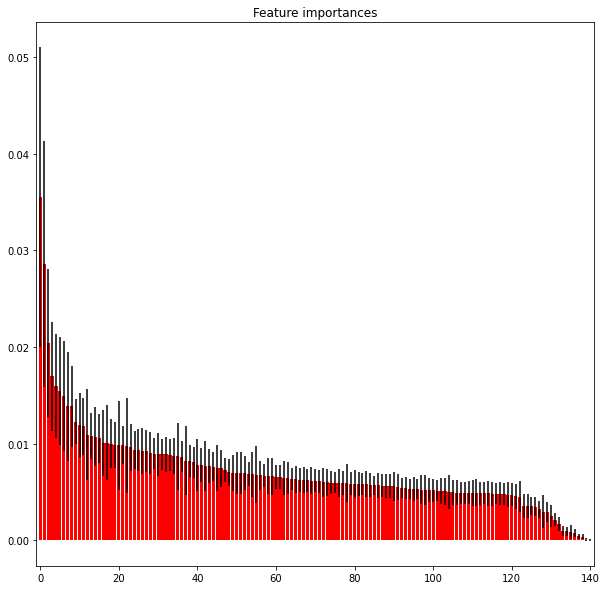

Feature ranking:
1. feature TFIDF_clean_thumb_ocr_text_V2_26 (0.035515)
2. feature TFIDF_title_clean_26 (0.028609)
3. feature TFIDF_title_clean_25 (0.020446)
4. feature TFIDF_title_clean_23 (0.016976)
5. feature TFIDF_title_clean_1 (0.015983)
6. feature TFIDF_clean_thumb_ocr_text_V2_23 (0.015476)
7. feature likes/views (0.014969)
8. feature TFIDF_title_clean_10 (0.013885)
9. feature TFIDF_title_clean_28 (0.013867)
10. feature channel_title (0.012288)
11. feature TFIDF_title_clean_17 (0.011962)
12. feature n_of_tags (0.011810)
13. feature title_punctuation_percent (0.010946)
14. feature TFIDF_title_clean_15 (0.010823)
15. feature title_capital_letters_percent (0.010716)
16. feature TFIDF_title_clean_29 (0.010553)
17. feature title_punctuation (0.010116)
18. feature TFIDF_clean_thumb_ocr_text_V2_15 (0.010094)
19. feature title_small_letters_percent (0.010005)
20. feature TFIDF_title_clean_27 (0.009867)
21. feature TFIDF_clean_thumb_ocr_text_V2_25 (0.009863)
22. feature desc_n_of_urls (0.

In [5]:
r1 = getFI_RForest(X,y)

## Feature Importance based on Bagging + Decision tree

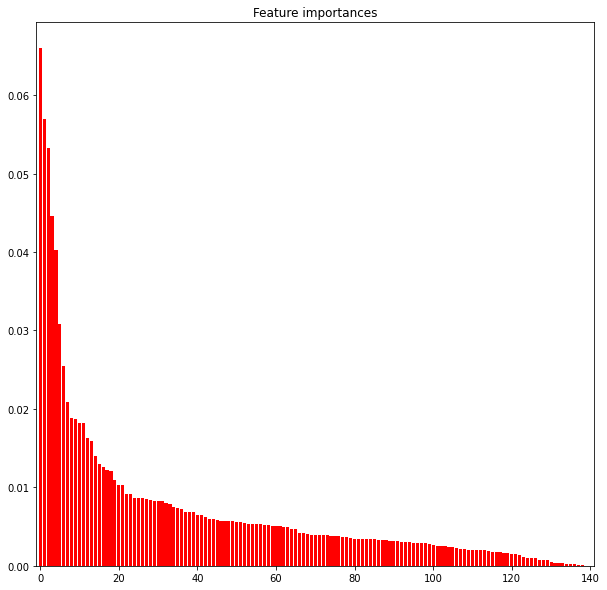

Feature ranking:
1. feature TFIDF_clean_thumb_ocr_text_V2_26 (0.066003)
2. feature TFIDF_title_clean_26 (0.057014)
3. feature TFIDF_title_clean_25 (0.053308)
4. feature TFIDF_title_clean_23 (0.044645)
5. feature TFIDF_title_clean_1 (0.040299)
6. feature TFIDF_clean_thumb_ocr_text_V2_23 (0.030839)
7. feature TFIDF_title_clean_28 (0.025480)
8. feature TFIDF_title_clean_15 (0.020942)
9. feature TFIDF_title_clean_29 (0.018873)
10. feature TFIDF_title_clean_17 (0.018730)
11. feature TFIDF_clean_thumb_ocr_text_V2_15 (0.018190)
12. feature TFIDF_title_clean_27 (0.018158)
13. feature TFIDF_clean_thumb_ocr_text_V2_28 (0.016288)
14. feature channel_title (0.015899)
15. feature TFIDF_title_clean_10 (0.013997)
16. feature TFIDF_clean_thumb_ocr_text_V2_10 (0.012925)
17. feature TFIDF_title_clean_24 (0.012542)
18. feature likes/views (0.012246)
19. feature n_of_tags (0.012104)
20. feature dislikes/likes (0.010957)
21. feature desc_n_of_words (0.010322)
22. feature title_capital_letters_percent (0.01

In [6]:
r3 = getFI_Bagging(X,y)

## Feature Importance based on LassoCV

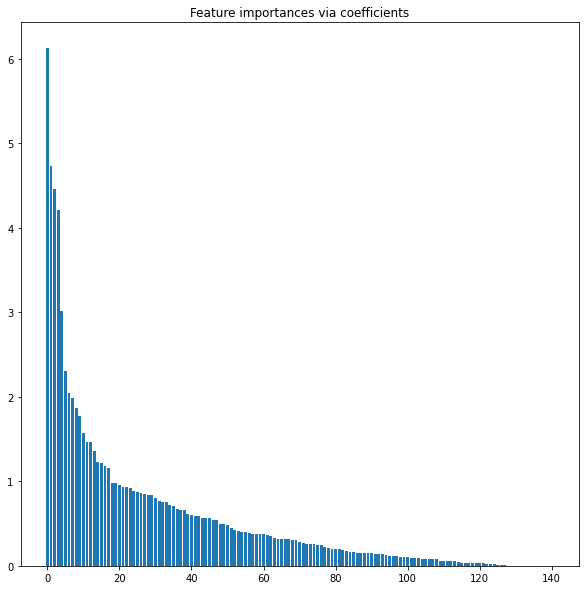

            0                                 1
7    6.129214            video_error_or_removed
6    4.728689                  ratings_disabled
111  4.466738           TFIDF_categories_str_26
109  4.207314           TFIDF_categories_str_10
119   3.01172           TFIDF_categories_str_28
118  2.309733           TFIDF_categories_str_23
77   2.043878              TFIDF_title_clean_10
70   1.987099                             faces
121  1.864658            TFIDF_categories_str_2
125  1.771684              TFIDF_objects_str_10
86   1.575054              TFIDF_title_clean_23
95   1.470585  TFIDF_clean_thumb_ocr_text_V2_26
93   1.465444  TFIDF_clean_thumb_ocr_text_V2_10
136  1.364115               TFIDF_objects_str_1
74   1.227818                             std_h
79   1.214851              TFIDF_title_clean_26
0    1.178396                     channel_title
59   1.160183                           entropy
128  0.985369              TFIDF_objects_str_24
5    0.985089                 comments_d

In [7]:
r2 = getFILasso(X,y)

## Selecting features based on  LinearSVC and sklearn SelectFromModel

In [8]:
r4 = selectFromModelSVC(X,y)

Before: (8509, 141)
After: (8509, 113)
Index(['channel_title', 'likes', 'dislikes', 'comment_count',
       'pub_day_of_the_week', 'pub_month', 'pub_day', 'pub_hour',
       'tren_day_of_the_week', 'tren_month',
       ...
       'TFIDF_categories_str_28', 'TFIDF_categories_str_1',
       'TFIDF_categories_str_2', 'TFIDF_categories_str_29',
       'TFIDF_categories_str_19', 'TFIDF_categories_str_43',
       'TFIDF_objects_str_22', 'TFIDF_objects_str_24', 'TFIDF_objects_str_20',
       'TFIDF_objects_str_19'],
      dtype='object', length=113)


# Intersection of 3 methods

In [14]:
r1 = r1.sort_values(by=[0], ascending=False)
r2 = r2.sort_values(by=[0], ascending=False)
r3 = r3.sort_values(by=[0], ascending=False)

In [48]:
k = 200
r1_k_best = r1.iloc[:k, [1]].values
r2_k_best = r2.iloc[:k, [1]].values
r3_k_best = r3.iloc[:k, [1]].values

# r1_set = set(r1_k_best.ravel().tolist())
# r2_set = set(r2_k_best.ravel().tolist())
# r3_set = set(r3_k_best.ravel().tolist())

# r1_set.intersection(r2_set ,r3_set)

In [49]:
r1_k_best.ravel().tolist()

['TFIDF_clean_thumb_ocr_text_V2_26',
 'TFIDF_title_clean_26',
 'TFIDF_title_clean_25',
 'TFIDF_title_clean_23',
 'TFIDF_title_clean_1',
 'TFIDF_clean_thumb_ocr_text_V2_23',
 'likes/views',
 'TFIDF_title_clean_10',
 'TFIDF_title_clean_28',
 'channel_title',
 'TFIDF_title_clean_17',
 'n_of_tags',
 'title_punctuation_percent',
 'TFIDF_title_clean_15',
 'title_capital_letters_percent',
 'TFIDF_title_clean_29',
 'title_punctuation',
 'TFIDF_clean_thumb_ocr_text_V2_15',
 'title_small_letters_percent',
 'TFIDF_title_clean_27',
 'TFIDF_clean_thumb_ocr_text_V2_25',
 'desc_n_of_urls',
 'TFIDF_clean_thumb_ocr_text_V2_28',
 'desc_punctuation_percent',
 'desc_length',
 'desc_small_letters',
 'title_small_letters',
 'desc_n_of_words',
 'title_capital_letters',
 'pub_hour',
 'TFIDF_title_clean_24',
 'desc_capital_letters',
 'desc_punctuation',
 'desc_capital_letters_percent',
 'title_length',
 'avg_texts_coordY',
 'desc_small_letters_percent',
 'TFIDF_clean_thumb_ocr_text_V2_10',
 'comment_count/view

In [50]:
r2_k_best.ravel().tolist()

['video_error_or_removed',
 'ratings_disabled',
 'TFIDF_categories_str_26',
 'TFIDF_categories_str_10',
 'TFIDF_categories_str_28',
 'TFIDF_categories_str_23',
 'TFIDF_title_clean_10',
 'faces',
 'TFIDF_categories_str_2',
 'TFIDF_objects_str_10',
 'TFIDF_title_clean_23',
 'TFIDF_clean_thumb_ocr_text_V2_26',
 'TFIDF_clean_thumb_ocr_text_V2_10',
 'TFIDF_objects_str_1',
 'std_h',
 'TFIDF_title_clean_26',
 'channel_title',
 'entropy',
 'TFIDF_objects_str_24',
 'comments_disabled',
 'mean_h',
 'TFIDF_clean_thumb_ocr_text_V2_23',
 'TFIDF_categories_str_1',
 'std_g',
 'desc_small_letters',
 'TFIDF_categories_str_19',
 'Neutral',
 'Sad',
 'Happy',
 'mean_v',
 'Angry',
 'TFIDF_categories_str_29',
 'likes/views',
 'std_v',
 'isTwitter',
 'TFIDF_objects_str_22',
 'likes',
 'desc_n_of_words',
 'TFIDF_title_clean_25',
 'std_b',
 'TFIDF_categories_str_22',
 'TFIDF_objects_str_43',
 'avg_views_increase_per_hour',
 'TFIDF_title_clean_22',
 'title_capital_letters_percent',
 'Fear',
 'TFIDF_title_clean_

In [51]:
r3_k_best.ravel().tolist()

['TFIDF_clean_thumb_ocr_text_V2_26',
 'TFIDF_title_clean_26',
 'TFIDF_title_clean_25',
 'TFIDF_title_clean_23',
 'TFIDF_title_clean_1',
 'TFIDF_clean_thumb_ocr_text_V2_23',
 'TFIDF_title_clean_28',
 'TFIDF_title_clean_15',
 'TFIDF_title_clean_29',
 'TFIDF_title_clean_17',
 'TFIDF_clean_thumb_ocr_text_V2_15',
 'TFIDF_title_clean_27',
 'TFIDF_clean_thumb_ocr_text_V2_28',
 'channel_title',
 'TFIDF_title_clean_10',
 'TFIDF_clean_thumb_ocr_text_V2_10',
 'TFIDF_title_clean_24',
 'likes/views',
 'n_of_tags',
 'dislikes/likes',
 'desc_n_of_words',
 'title_capital_letters_percent',
 'desc_small_letters_percent',
 'title_punctuation_percent',
 'TFIDF_clean_thumb_ocr_text_V2_2',
 'title_small_letters_percent',
 'desc_capital_letters',
 'desc_punctuation_percent',
 'pub_hour',
 'desc_punctuation',
 'desc_capital_letters_percent',
 'title_length',
 'title_small_letters',
 'dislikes/views',
 'desc_small_letters',
 'entropy',
 'desc_n_of_urls',
 'comment_count/views',
 'title_capital_letters',
 'time